In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import faiss
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import joblib


/Users/christopherli/ML/RecipeImageClassifier/venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Setting Up Training for CNN Model

### 1.1 Configurations:

In [2]:
DATA_DIR = "data/images"  # root folder with subfolders for each meta topic
IMG_SIZE = (224, 224)                   # keep your 224x224 images
BATCH_SIZE = 32
NUM_CLASSES = 90                         # number of meta topics
EPOCHS = 3
FINE_TUNING_EPOCHS = 5
LEARNING_RATE = 1e-5

### 1.2 Dataset Splitting and Generation

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation split
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 38861 images belonging to 90 classes.


In [5]:
val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 9671 images belonging to 90 classes.


### 1.3 Loading Model 

In [6]:
base_model = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

In [7]:
base_model.trainable = False


## 2. Training Model

In [8]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Epoch 1/3
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 1274s 1s/step - accuracy: 0.0914 - loss: 4.3880 - val_accuracy: 0.1335 - val_loss: 3.8430
Epoch 2/3
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 1325s 1s/step - accuracy: 0.1152 - loss: 3.9362 - val_accuracy: 0.1371 - val_loss: 3.8084
Epoch 3/3
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 1434s 1s/step - accuracy: 0.1224 - loss: 3.8925 - val_accuracy: 0.1391 - val_loss: 3.8086


In [11]:
base_model.trainable = True

# Freeze all but the top 40 layers
for layer in base_model.layers[:-40]:
    layer.trainable = False

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("food_model.keras",monitor='val_accuracy', save_best_only=True)
    ] 


In [14]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=FINE_TUNING_EPOCHS
)

Epoch 1/20
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 1843s 2s/step - accuracy: 0.1248 - loss: 3.8547 - val_accuracy: 0.1445 - val_loss: 3.7885
Epoch 2/20
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 2060s 2s/step - accuracy: 0.1380 - loss: 3.7725 - val_accuracy: 0.1490 - val_loss: 3.7631
Epoch 3/20
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 1601s 1s/step - accuracy: 0.1420 - loss: 3.7426 - val_accuracy: 0.1548 - val_loss: 3.7502
Epoch 4/20
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 2039s 2s/step - accuracy: 0.1486 - loss: 3.7130 - val_accuracy: 0.1564 - val_loss: 3.7439
Epoch 5/20
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 1747s 1s/step - accuracy: 0.1540 - loss: 3.6812 - val_accuracy: 0.1573 - val_loss: 3.7382
Epoch 6/20
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 1955s 2s/step - accuracy: 0.1538 - loss: 3.6609 - val_accuracy: 0.1597 - val_loss: 3.7241
Epoch 7/20
  47/1215 ━━━━━━━━━━━━━━━━━━━━ 27:59 1s/step - accuracy: 0.1702 - loss: 3.6124

KeyboardInterrupt: 

In [55]:
base_model.trainable = True

# Freeze bottom ~100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False

In [56]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [59]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=FINE_TUNING_EPOCHS
)

Epoch 1/5
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 1755s 1s/step - accuracy: 0.1603 - loss: 3.6279 - val_accuracy: 0.1633 - val_loss: 3.7196
Epoch 2/5
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 2233s 2s/step - accuracy: 0.1617 - loss: 3.6097 - val_accuracy: 0.1605 - val_loss: 3.7326
Epoch 3/5
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 2312s 2s/step - accuracy: 0.1667 - loss: 3.5893 - val_accuracy: 0.1627 - val_loss: 3.7131
Epoch 4/5
  24/1215 ━━━━━━━━━━━━━━━━━━━━ 25:15 1s/step - accuracy: 0.1767 - loss: 3.5920

KeyboardInterrupt: 

In [60]:
model.save("food_model.keras")

## 3. Performing PCA

In [10]:
model = tf.keras.models.load_model("../artifacts/model_training/food_model.keras")

In [11]:
embedding_model = Model(
    inputs=model.input,
    outputs=model.get_layer(index=-3).output
)

embedding_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,860,064 (87.20 MB)

 Trainable params: 7,126,912 (27.19 MB)

 Non-trainable params: 15,733,152 (60.02 MB)

In [12]:
embed_datagen = ImageDataGenerator(rescale=1./255)

embed_generator = embed_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 48532 images belonging to 90 classes.


In [13]:
embeddings = embedding_model.predict(embed_generator, verbose=1)

labels = embed_generator.classes          # integer class labels
class_names = list(embed_generator.class_indices.keys())

print("Embeddings shape:", embeddings.shape)

1517/1517 ━━━━━━━━━━━━━━━━━━━━ 1540s 1s/step
Embeddings shape: (48532, 512)


In [131]:
embedding_model.save("embedding_model.keras")

In [14]:
embeddings_norm = normalize(embeddings, axis=1) 

In [15]:
pca = PCA(n_components=0.95, random_state=42)
embeddings_pca = pca.fit_transform(embeddings_norm)

print("PCA embeddings shape:", embeddings_pca.shape)
explained_variance = sum(pca.explained_variance_ratio_)
print("Explained variance:", explained_variance)

PCA embeddings shape: (48532, 260)
Explained variance: 0.9502917


In [28]:
joblib.dump(pca, "pca.joblib")

['pca.joblib']

## 4. Performing ANN

In [16]:
image_paths = []

for cls in sorted(os.listdir(DATA_DIR)):
    cls_dir = os.path.join(DATA_DIR, cls)

    if not os.path.isdir(cls_dir):
        continue

    for fname in sorted(os.listdir(cls_dir)):
        if fname.startswith("."):
            continue

        image_paths.append(os.path.join(cls_dir, fname))

image_paths = np.array(image_paths)

print("Total images:", len(image_paths))

Total images: 48532


In [32]:
d = embeddings_pca.shape[1]            # PCA dimension
index = faiss.IndexFlatL2(d)           # FAISS index
index.add(embeddings_pca)              # Add embeddings in same order
print("ANN index size:", index.ntotal)
print("FAISS index size:", index.ntotal)

print("FAISS index dim:", index.d)
print("PCA components:", pca.n_components_)


ANN index size: 48532
FAISS index size: 48532
FAISS index dim: 260
PCA components: 260


In [33]:
faiss.write_index(index, "recipes.faiss")

In [23]:
def show_neighbors(idx, k=5):
    # --- Use PCA embeddings, not raw embeddings ---
    query = embeddings_pca[idx].reshape(1, -1).astype("float32")

    # Safety check (helps debugging)
    assert query.shape[1] == index.d, (
        f"Query dim {query.shape[1]} != FAISS dim {index.d}"
    )

    distances, indices = index.search(query, k + 1)  # +1 to skip self

    print(f"Query image: {image_paths[idx]}")
    print("Query class:", class_names[labels[idx]])

    # --- Plot ---
    fig, axes = plt.subplots(1, k + 1, figsize=(4 * (k + 1), 4))

    # Query image
    img = load_img(image_paths[idx], target_size=IMG_SIZE)
    axes[0].imshow(img)
    axes[0].set_title(f"QUERY\n{class_names[labels[idx]]}")
    axes[0].axis("off")

    # Neighbor images (skip self at index 0)
    for i, neighbor_idx in enumerate(indices[0][1:]):
        neighbor_img = load_img(image_paths[neighbor_idx], target_size=IMG_SIZE)
        axes[i + 1].imshow(neighbor_img)
        axes[i + 1].set_title(
            f"{class_names[labels[neighbor_idx]]}\n"
            f"d={distances[0][i + 1]:.2f}"
        )
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()


Query image: data/images/meta_topic_1/blueberry_sour_cream_coffee_cake_19316.jpg
Query class: meta_topic_1


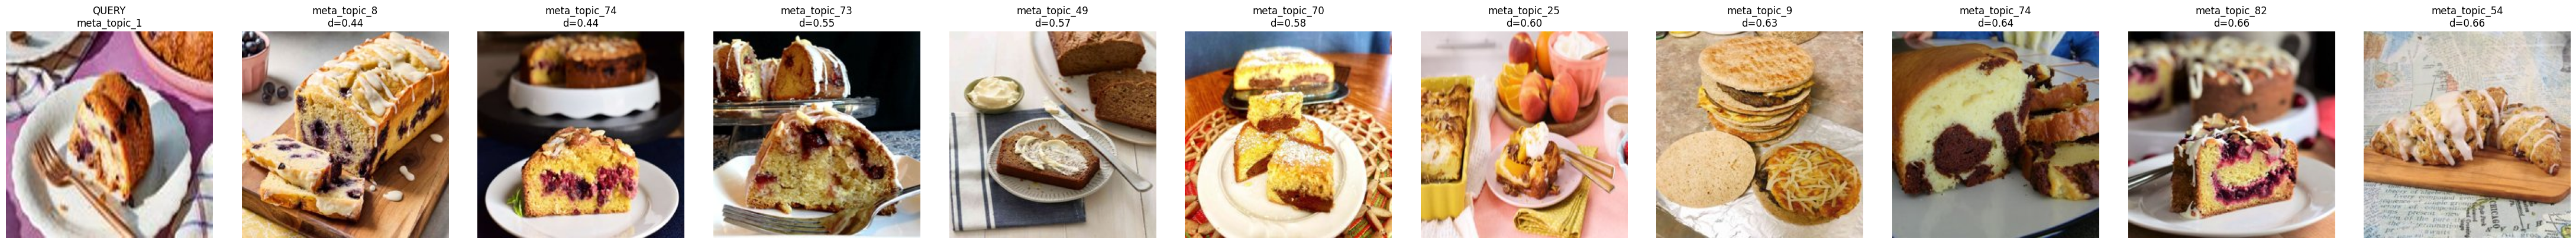

In [25]:
show_neighbors(101, k=10)

In [136]:
np.save("image_paths.npy", image_paths)
np.save("labels.npy", labels)